# MMA 2022S 865, Individual Assignment 1

Version 2: Updated January 1, 2022.

- Gopala Goyal
- 20254605
- 2
- January 8, 2022

# Question 1 - ELI5

_“If you can't explain it simply, you don't understand it well enough.” – Albert Einstein_

Explaining technical concepts to a non-technical audience is an underappreciated skill; one which the GMMA/MMA program aims to give its students; and one that will truly set you apart in the job market. The only way to gain a skill is by practice, so here we go.

Answer each question below as though you were talking to a 5 year old (equivalently: a grandma, or a completely non-technical manager, or an Ivey grad). Use your own words. Use analogies where possible. Examples are better than theory. Keep it short, but be complete. Use simple, plain English. Do not use business buzzwords like _actualize, empower, fungible, leverage, or synergize_. Do not use technical buzzwords that most people don’t know like _model, agile, bandwidth, IoT, blockchain, AR, VR, actionable insights_. Inform the audience without going into too much technical detail. Your goal is to truly help them understand, not to give what you feel is a “technically precise” answer and move on (but they still don’t understand!). Don’t be that guy!

Please keep each answer to 1000 characters or less.

Finally, feel free to use [Markdown syntax](https://www.markdownguide.org/basic-syntax/) to format your answer.


### Part 1: What is “Big Data” and how is it different than “regular data”?

TODO: Insert your answer here.

### Part 2: What is Hadoop? Hint: What problems in previous data storage and processing was Hadoop designed to solve? How did Hadoop accomplish that?

TODO: Insert your answer here.

### Part 3: How does Big Data and the cloud help Machine Learning? 

TODO: Insert your answer here.

### Part 4: What is NoSQL?

TODO: Insert your answer here.

### Part 5: Name three ways topic modeling could help a bank.

TODO: Insert your answer here.

### Part 6: What is Apache Spark, exactly, and what are its pros and cons?

TODO: Insert your answer here.

# Question 2: Sentiment Analysis via the ML-based approach

Download the “Product Sentiment” dataset from the course portal: sentiment_train.csv and sentiment_test.csv.

### Part 1.a. Loading and Prep

Load, clean, and preprocess the data as you find necessary.

In [77]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
import re

In [80]:
nltk.download("all")

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /Users/apple/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     /Users/apple/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /Users/apple/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /Users/apple/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /Users/apple/nltk_data...
[nltk_data]    |   Unzipping grammars/basque_grammars.zip.
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /Users/apple/nltk_data...
[nltk_data]    |   Unz

[nltk_data]    | Downloading package pe08 to /Users/apple/nltk_data...
[nltk_data]    |   Unzipping corpora/pe08.zip.
[nltk_data]    | Downloading package perluniprops to
[nltk_data]    |     /Users/apple/nltk_data...
[nltk_data]    |   Unzipping misc/perluniprops.zip.
[nltk_data]    | Downloading package pil to /Users/apple/nltk_data...
[nltk_data]    |   Unzipping corpora/pil.zip.
[nltk_data]    | Downloading package pl196x to
[nltk_data]    |     /Users/apple/nltk_data...
[nltk_data]    |   Unzipping corpora/pl196x.zip.
[nltk_data]    | Downloading package porter_test to
[nltk_data]    |     /Users/apple/nltk_data...
[nltk_data]    |   Unzipping stemmers/porter_test.zip.
[nltk_data]    | Downloading package ppattach to
[nltk_data]    |     /Users/apple/nltk_data...
[nltk_data]    |   Unzipping corpora/ppattach.zip.
[nltk_data]    | Downloading package problem_reports to
[nltk_data]    |     /Users/apple/nltk_data...
[nltk_data]    |   Unzipping corpora/problem_reports.zip.
[nltk_dat

True

In [132]:
import pandas as pd
# TODO: import other libraries as necessary

df_train = pd.read_csv("sentiment_train.csv")

print(df_train.info())
print(df_train.head())

df_test = pd.read_csv("sentiment_test.csv")

print(df_test.info())
print(df_test.head())

# TODO

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2400 entries, 0 to 2399
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sentence  2400 non-null   object
 1   Polarity  2400 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 37.6+ KB
None
                                            Sentence  Polarity
0                           Wow... Loved this place.         1
1                                 Crust is not good.         0
2          Not tasty and the texture was just nasty.         0
3  Stopped by during the late May bank holiday of...         1
4  The selection on the menu was great and so wer...         1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sentence  600 non-null    object
 1   Polarity  600 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 9.5+ KB
No

### EDA

<AxesSubplot:>

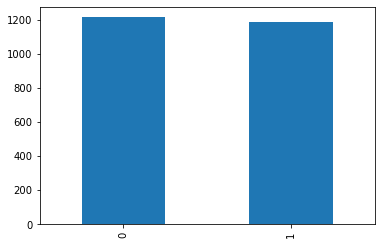

In [16]:
df_train.Polarity.value_counts().plot.bar()

> Data is balanced

In [3]:
# Cleaning
# Tokenization
# Removing Stop Words
# Removing punctuation and character
# Spelling correction
# Lemmatization or Stemming - Standardizing the word

### Check missing/wrong values

In [133]:
df_train['review_length']  = df_train.Sentence.str.split().str.len()

In [134]:
df_train[df_train.review_length==1]

,Sentence,Polarity,review_length
26,#NAME?,0,1
71,#NAME?,1,1
165,DELICIOUS!!,1,1
219,#NAME?,1,1
904,#NAME?,0,1
1185,Incredible!.,1,1
1463,Disappointed!.,0,1
1751,disappointing.,0,1
1777,WORTHWHILE.,1,1
1877,Excellent!.,1,1


> We need to remove the rows with data as '#NAME?'

In [135]:
df_train = df_train.drop(df_train[df_train.Sentence == "#NAME?"].index).reset_index(drop = True)

In [136]:
df_train

,Sentence,Polarity,review_length
0,Wow... Loved this place.,1,4
1,Crust is not good.,0,4
2,Not tasty and the texture was just nasty.,0,8
3,Stopped by during the late May bank holiday of...,1,15
4,The selection on the menu was great and so wer...,1,12
...,...,...,...
2391,Almost all of the songs in Cover Girl are old-...,0,14
2392,The most annoying thing about 'Cover Girl' is ...,0,20
2393,"Unfortunately, 'Cover Girl' is an example of h...",0,16
2394,Non-linear narration thus many flashbacks and ...,1,12


In [137]:
#Method to clean data
#Remove punctuations
#Remove numbers
#Lowercase the string
#Split the strings on white spaces
#Remove Stopwords
#Lemmatization

lemmatizer = WordNetLemmatizer()
def text_cleaner(text):
    r = text.translate(str.maketrans("","",string.punctuation)) 
    r = re.sub(r'\d+', '',r) 
    r = r.lower()
    r = r.split()
    r = [word for word in r if word not in stopwords.words('english')]
    r = [lemmatizer.lemmatize(word) for word in r]
    r = ' '.join(r)
    return r

In [138]:
df_train['clean_sentence'] = df_train.Sentence.apply(lambda text:text_cleaner(text))
df_train['review_length']  = df_train.clean_sentence.str.split().str.len()

In [139]:
X = df_train.drop(columns  = ["Polarity"])
y = df_train.Polarity

In [140]:
from sklearn.feature_extraction.text import TfidfVectorizer
cv = TfidfVectorizer()
X_cv = cv.fit_transform(X.clean_sentence)

In [141]:
X = pd.concat([X,pd.DataFrame(data=X_cv.toarray(), columns = cv.get_feature_names())],axis = 1).drop(columns = ['Sentence','clean_sentence'])

In [144]:
X.ability.unique()

array([0.        , 0.33417507, 0.4701615 ])

### Part 1.b. Modeling

Use your favorite ML algorithm to train a classification model.  Don’t forget everything that we’ve learned in our ML course: hyperparameter tuning, cross validation, handling imbalanced data, etc. Make reasonable decisions and try to create the best-performing classifier that you can.

In [2]:
# TODO

### Part 1.c. Assessing

Use the testing data to measure the accuracy and F1-score of your model.  

In [ ]:
# TODO

### Part 2. Given the accuracy and F1-score of your model, are you satisfied with the results, from a business point of view? Explain.

TODO: Insert your answer here.

### Part 3. Show five example instances in which your model’s predictions were incorrect. Describe why you think the model was wrong. Don’t just guess: dig deep to figure out the root cause.

TODO: Insert your answer here.

In [3]:
# TODO: Feel free to use code as well to answer this question. Or not. Up to you.